# Natural Language Processing

One element that all neural networks that process text have in common is an embedding layer which uses word embeddings to transform arrays or sequences of scalar values representing words into arrays of floating-point numbers called word vectors. These vectors encode information aboout the meaning of words and relationship between them. The output of an embedding layer can be the input to a classification layer or it can be input to other types of neural network layers to tease more meaning from it before subjecting it to further processing.

## Text Preparation

CountVectorizer class from Scikit-Learn transforms rows of text into rows of word counts.
1. removes punctuation and numbers
2. converts all characters to lower-case
3. (optional) removes stop words

Vectorization is performed differently. Instead of creating a table of word counts it creates a table of sequences containing tokens representing individual words. Keras provides the Tokenizer class which is an equivalent of CountVectorizer but for deep-learning.

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer

lines = [
    'The quick brown fox',
    'Jumps over $$$ the lazy brown dog',
    'Who jumps high into the blue sky after counting 123',
    'And quickly returns to earth'
]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

2026-01-11 17:37:06.564436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768149426.670623  853751 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768149426.698631  853751 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768149426.939424  853751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768149426.939443  853751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768149426.939444  853751 computation_placer.cc:177] computation placer alr

In [2]:
sequences

[[1, 4, 2, 5],
 [3, 6, 1, 7, 2, 8],
 [9, 3, 10, 11, 1, 12, 13, 14, 15, 16],
 [17, 18, 19, 20, 21]]

In [3]:
words = tokenizer.sequences_to_texts(sequences)

In [4]:
words

['the quick brown fox',
 'jumps over the lazy brown dog',
 'who jumps high into the blue sky after counting 123',
 'and quickly returns to earth']

Words are converted to lower case and symbols are removed but stop words and numbers are still there.

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/nb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

lines = [
    'The quick brown fox',
    'Jumps over $$$ the lazy brown dog',
    'Who jumps high into the blue sky after counting 123',
    'And quickly returns to earth'
]

def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
lines = list(map(remove_stop_words, lines))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [7]:
sequences

[[3, 1, 4], [2, 5, 1, 6], [2, 7, 8, 9, 10], [11, 12, 13]]

In [8]:
words = tokenizer.sequences_to_texts(sequences)
words

['quick brown fox',
 'jumps lazy brown dog',
 'jumps high blue sky counting',
 'quickly returns earth']

Now the numbers and stop words have been removed. The sequences vary in range but a neural network expects all sequences to be the same length. Keras pad_sequences function performs this by truncating sequences longer than the specified length and padding sequencse shorter than the specified length with 0s.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(sequences, maxlen=4)

In [10]:
padded_sequences

array([[ 0,  3,  1,  4],
       [ 2,  5,  1,  6],
       [ 7,  8,  9, 10],
       [ 0, 11, 12, 13]], dtype=int32)

The text input to a neural network for predictions has to be tokenized and padded the same way as text input to the model for training. To avoid doing this manually you can include a TextVectorization layer in the model.

## Word Embeddings

Another important element is converting padded sequences of word tokens into arrays of word vectors which represent each word with an array vector of floating-point numbers rather than a single integer. Each word in the input text is represented by a vector in the embedding layer and as the network is trained vectors representint individual words are adjusted to reflect their relationship to one another. If you are building a sentiment analysis model words such as excellent and amazing have similar connotations and the vectors representation of those words in the embedding space should be close together. The keras Embedding class can do the word embedding and has 3 parameters:
1. The vocabulary size - number of words in the bocabulary built by the Tokenizer
2. The number of dimensions in the embedding space - usually a number from 32 to 512 the more dimensions the more fitting power but also increased training time, each word gets encoded in the embedding space as m dimensional vector.
3. The length of each padded sequence


The vectors that represent individual words in an embedding layer are learnied during training just as the weights connecting neurons in adjacent dense layers are learned. If there are not enough training samples you could initialize the embedding layer with pretrained word embeddings rather than rely on it to learn the word embeddings on its own.

## Text Classification

Sequences of tokenized text are input into the embedding layer, the output from the embedding layer is a 2D matrix of floating-point numbers measuring m by n where m is the number of dimensions in the embedding space and n is the sequence length, then the flatten layer flattens the 2D output into a 1D array suitable for input to a dense layer which classifies the values.

In [11]:
import pandas as pd

df = pd.read_csv('Data/ham-spam.csv')
df = df.sample(frac=1, random_state=0)
df.head()

,IsSpam,Text
993,1,utf date course utf diminish weight our table...
859,1,utf any drugs eur utf for dose have you ever ...
298,0,expert finderhttps expertfinder enron com
553,1,and courtiers ministerssubsegment founded res...
672,1,for our clients fargo dear customer have updat...


In [12]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499  cinergy closingthe closing schedule for the sa...    1
1        500    500   offer variety different licenses and discount...    1

In [13]:
x = df['Text']
y = df['IsSpam']

max_words = 10000
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding

model = Sequential()
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/home/nb/Projects/AppliedML/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2026-01-11 17:37:12.130463: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6571 - loss: 0.6165 - val_accuracy: 0.7550 - val_loss: 0.4731
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8999 - loss: 0.2646 - val_accuracy: 0.9350 - val_loss: 0.1618
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9850 - loss: 0.0547 - val_accuracy: 0.9350 - val_loss: 0.1383
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9925 - loss: 0.0248 - val_accuracy: 0.9600 - val_loss: 0.1267
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9937 - loss: 0.0140 - val_accuracy: 0.9550 - val_loss: 0.1292


[]

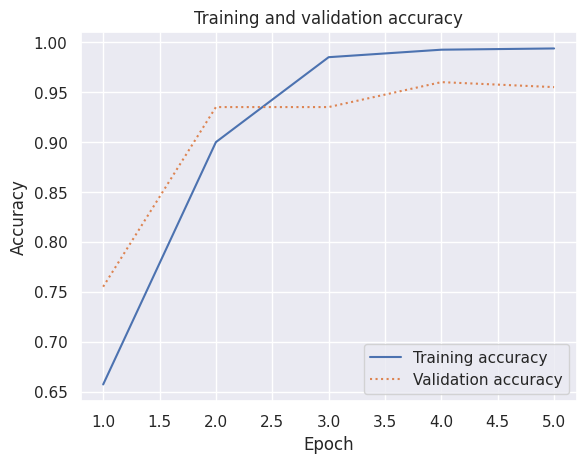

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [17]:
text = 'Can you attend a code review on Tuesday? Need to make sure the logic is rock solid.'

sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


np.float32(0.2624427)

In [18]:
text = 'Why pay more for expensive meds when you can order them online and save $$$?'

sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


np.float32(0.99128973)

## Using TextVectorization in a Sentiment Analysis Model

In [19]:
df = pd.read_csv('Data/reviews.csv', encoding='ISO-8859-1"')
df = df.sample(frac=1, random_state=0)
df.head()

,Text,Sentiment
11841,Al Pacino was once an actor capable of making ...,0
19602,After Chaplin made one of his best films: Doug...,0
45519,This movie is sort of a Carrie meets Heavy Met...,1
25747,I have fond memories of watching this visually...,1
42642,"In the '70s, Charlton Heston starred in sci-fi...",1


In [20]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  What could've been a great film about the late...   
1          24884  24884  I really enjoyed this film. All aspects of the...   

                
          freq  
Sentiment       
0            1  
1            1

In [21]:
from tensorflow.keras.layers import TextVectorization, InputLayer
import tensorflow as tf
import numpy as np

max_words = 20000
max_length = 500

model = Sequential()
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_words, output_sequence_length=max_length))
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/home/nb/Projects/AppliedML/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/nb/Projects/AppliedML/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 500)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 500, 32)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,048,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,688,257 (10.25 MB)

 Trainable params: 2,688,257 (10.25 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
x = df['Text']
y = df['Sentiment']
model.layers[0].adapt(x)

#hist = model.fit(x, y, validation_split=0.5, epochs=5, batch_size=250)

ValueError: Invalid dtype: object

## Factoring Word Order into Prediction

Sometimes word order adds to the meaning of words. For example credit and card when appearing close to each other have a different meaning than if they are far appart in a senence. One way to do this is to use n-grams which can be used as a parameter in the TextVectorization class.
Another way to do this is to replace the dense layers with 1D convolutional and MaxPooling layers.

## Recurrent Neural Networks (RNNs)

Initially developed to process time-series data, good at detecting trends and factor them in the output. A sequence of words can be treated as time series data since words that come earlier in a sentence can inform on how words that occur later can be interpreted. This works well for short sequences of a few words but for longer sequences this method suffers from a vanishing-gradient effect which means that words far apart will exert little influence over one another. One solution is a recurrent layer composed of Long Short-Term Memory (LSTM). LSTM cells are miniature neural networks in their own right. As the cell loop over the words in a sequence they learn which words are important and lend that information precedence in subsequent iterations throught the loop.

## LSTM Encoder-Decoders

LSTM layers encode a tokenized input sequence representing the phrase to be translated into a vector. A second set of recurrent layers uses that vector as input and decodes it into a tokenized phrase in another language, the model accepts sequences as input and returns sequences as output. A softmax output layer at the end outputs a set of probabilities for each token in the output sequence.

## Transformer Encoder-Decoders

Transformers propose a better way to perform sequence-to-sequence processing based on transformer models, they use attention mechanisms to model the context in which words are used.
The main innovation itroduced by the transformer model is the use of multi-headed attention (MHA) layers in place of LSTM layers. MHA layers embody the concept of self-attention which enables a model to analyze an input sequence and focus on the words that are most important as well as the context in which the words are used.

## Building a Transformer-Based NMT Model

In [26]:
df = pd.read_csv('Data/en-fr.txt', names=['en','fr','attr'], usecols=['en','fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


In [27]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


In [28]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 7
Max phrase length (French): 16
Sequence length: 16


In [30]:
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len + 1, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

In [31]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12197


In [32]:
inputs = {'encoder_input': en_x, 'decoder_input': fr_y[:, :-1]}
outputs = fr_y[:, 1:]

In [34]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder
from keras_nlp.layers import TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

num_heads = 8
embed_dim = 256

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_input)
encoder_output = TransformerEncoder(embed_dim, num_heads)(x)
encoded_seq_input = Input(shape=(None, embed_dim))

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_input)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_input)
x = Dropout(0.4)(x)

decoder_output = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_input, encoded_seq_input], decoder_output)
decoder_output = decoder([decoder_input, encoder_output])

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=100)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)  │ (None, None)            │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ token_and_position_embeddi… │ (None, None, 256)       │      1,548,544 │ encoder_input[0][0]     │
│ (TokenAndPositionEmbedding) │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ decoder_input (InputLayer)  │ (None, None)            │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ transformer_encoder         │ (None, None, 256)       │        395,776 │ token_and_position_emb… │
│ (TransformerEncoder)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ functional_6 (Functional)   │ (None, None, 12197)     │      6,920,613 │ decoder_input[0][0],    │
│                             │                         │                │ transformer_encoder[0]… │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 8,864,933 (33.82 MB)

 Trainable params: 8,864,933 (33.82 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

hist = model.fit(inputs, outputs, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50


ValueError: Paddings must be non-negative for '{{node gradient_tape/functional_7_1/token_and_position_embedding_1_1/position_embedding_1/Pad}} = Pad[T=DT_FLOAT, Tpaddings=DT_INT32](gradient_tape/functional_7_1/token_and_position_embedding_1_1/position_embedding_1/Reshape, gradient_tape/functional_7_1/token_and_position_embedding_1_1/position_embedding_1/concat)' with input shapes: [17,256], [2,2] and with computed input tensors: input[1] = <[0 -1][0 0]>.